# Find the Measured Velocities


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [3]:
from src.walk_configs import walk_configs
from constants import experiment_path, default_experiment_path


In [4]:
configs = list(walk_configs(experiment_path))
default_configs = list(walk_configs(default_experiment_path))


In [5]:
len(configs)


90

In [77]:
df = pd.read_parquet(configs[0].Blocks.XMLConvertConfig.target)


In [78]:
df.head()


,time,id,x,y,z,angle,type,speed,pos,lane
0,11.30,2_0_16.0,813.43,753.16,48.75,74.98,vehDist_469,22.56,260.05,834845345#1_1
1,11.40,2_0_16.0,815.61,753.75,48.75,74.98,vehDist_469,22.56,262.31,834845345#1_1
2,11.50,2_0_16.0,817.79,754.33,48.74,74.98,vehDist_469,22.56,264.57,834845345#1_1
3,11.60,2_0_16.0,819.97,754.92,48.74,74.98,vehDist_469,22.56,266.82,834845345#1_1
4,11.70,2_0_16.0,822.15,755.50,48.74,74.98,vehDist_469,22.56,269.08,834845345#1_1


### Read the File


In [6]:
import pandas as pd


def get_summary_df(config, box: str, additional_params: dict = None) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    df = pd.read_parquet(Path(config.Metadata.cwd) / f"{box}_summary_df.parquet")
    for key, value in additional_params.items():
        df[key] = value
    return df


def get_fuel(config, **aditional_params) -> float:
    # pandas
    df = pd.read_csv(
        config.Blocks.FuelTotalConfig.output_path, header=None, names=["time", "fuel"]
    )
    for param, value in aditional_params.items():
        df[param] = value
    return df


In [7]:
west_thru_dfs = []
east_thru_dfs = []
for config in tqdm(configs):
    additional_params = {
        "carFollowingModel": config.Blocks.CFTableConfig.additional_params.carFollowModel,
        "seed": config.Blocks.SeedConfig.seed,
    }
    east_thru_dfs.append(
        get_summary_df(
            config, box="Radar137_East_thru", additional_params=additional_params
        )
    )
east_thru_df = pd.concat(east_thru_dfs)


100%|██████████| 90/90 [00:10<00:00,  8.27it/s]


In [8]:
east_thru_dfs = []
for config in tqdm(default_configs):
    additional_params = {
        "carFollowingModel": config.Blocks.CFSimpleConfig.cf_params.carFollowModel,
        "seed": config.Blocks.SeedConfig.seed,
    }
    east_thru_dfs.append(
        get_summary_df(
            config, box="Radar137_East_thru", additional_params=additional_params
        )
    )
default_east_thru_df = pd.concat(east_thru_dfs)
default_east_thru_df["carFollowingModel"] = (
    default_east_thru_df["carFollowingModel"] + " (default)"
)


100%|██████████| 90/90 [00:10<00:00,  8.96it/s]


In [9]:
east_thru_df = pd.concat([east_thru_df, default_east_thru_df])


### Get the Fuel Consumption


In [10]:
fuel = [
    get_fuel(
        config,
        **{
            "carFollowModel": config.Blocks.CFTableConfig.additional_params.carFollowModel,
            "seed": config.Blocks.SeedConfig.seed,
        },
    )
    for config in configs
]
fuel_df = pd.concat(fuel)
SUMO_GASOLINE_GRAM_TO_JOULE: float = 43.4e-3


In [11]:
fuel = [
    get_fuel(
        config,
        **{
            "carFollowModel": config.Blocks.CFSimpleConfig.cf_params.carFollowModel,
            "seed": config.Blocks.SeedConfig.seed,
        },
    )
    for config in default_configs
]
fuel_df_defaults = pd.concat(fuel)


In [12]:
fuel_df_defaults["carFollowModel"] = fuel_df_defaults["carFollowModel"] + " (default)"
fuel_df = pd.concat([fuel_df, fuel_df_defaults])
fuel_df["fuel"] = (fuel_df["fuel"] / SUMO_GASOLINE_GRAM_TO_JOULE) * 0.00133529


In [13]:
fuel_df = fuel_df.groupby(["carFollowModel", "seed"]).sum().reset_index()


## Read the RW Data


In [14]:
rw_df = pd.read_parquet(ROOT / "data" / "rw_east_thru_summary.parquet")


## Plot the Histograms


(0.0, 3.0)

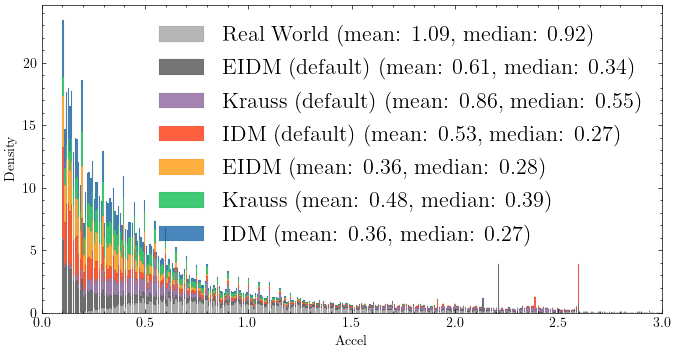

In [15]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["r2"] > 0.9) & (east_thru_df["type"] == "accel")
]

# concatenate the rw data
accel_rw_df = rw_df[(rw_df["r2"] > 0.9) & (rw_df["type"] == "accel")].copy()
accel_rw_df["carFollowingModel"] = "Real World"

plot_df = pd.concat([accel_sumo_df, accel_rw_df])


sns.histplot(
    data=plot_df,
    x="slope",
    hue="carFollowingModel",
    stat="density",
    ax=ax,
    common_norm=False,
    multiple="stack",
    shrink=0.8,
)
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [t.get_text() for t in ax.get_legend().get_texts()][::-1]
labels = [
    f"{label} (mean: {plot_df[plot_df['carFollowingModel'] == label]['slope'].mean():.2f}, median: {plot_df[plot_df['carFollowingModel'] == label]['slope'].median():.2f})"
    for label in labels
]
ax.legend(labels=labels)

# set the x and y axis labels
ax.set_xlabel("Accel")
ax.set_ylabel("Density")

# set the x and y axis limits
ax.set_xlim(0, 3)


In [16]:
east_thru_df


,vehicle_id,mean_time,total_seconds,break,y0,speed,slope,r2,rmse,start,end,type,minimum_time,carFollowingModel,seed
0,0_0_1.0,85.3,9.4,0,15.013804,14.012609,-0.910178,0.999977,0.002913,0.000000,2.263420,decel,2.263420,IDM,654
1,0_0_1.0,85.3,9.4,1,13.246715,12.793600,-0.129461,0.460666,0.101013,2.263420,4.773595,decel,2.510175,IDM,654
2,0_0_1.0,85.3,9.4,2,3.790020,14.714348,1.851581,0.999619,0.023993,4.773595,7.019847,accel,2.246252,IDM,654
3,0_0_1.0,85.3,9.4,3,17.452215,16.714000,-0.094643,0.150218,0.097256,7.019847,8.534183,cruise,1.514335,IDM,654
4,0_0_1.0,85.3,9.4,4,3.658338,17.277250,1.521666,0.999622,0.006840,8.534183,9.400000,accel,0.865817,IDM,654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11036,3_9000_1.2,9003.7,5.8,0,23.200019,23.214987,0.099787,0.999994,0.000027,0.000000,0.353780,cruise,0.353780,IDM (default),104
11037,3_9000_1.2,9003.7,5.8,1,23.213439,23.269108,0.061854,0.979660,0.002817,0.353780,1.416713,cruise,1.062932,IDM (default),104
11038,3_9000_1.2,9003.7,5.8,2,23.255994,23.325990,0.031816,0.955718,0.002956,1.416713,2.945157,cruise,1.528444,IDM (default),104
11039,3_9000_1.2,9003.7,5.8,3,23.301696,23.365260,0.016298,0.906603,0.002868,2.945157,4.806750,cruise,1.861593,IDM (default),104


In [ ]:
import numpy as np


def create_table(
    r2_threshold,
    type,
    plot_col,
):
    # plotting acceleration with r2 > 0.9
    if type == "cruise":
        metric_col = "rmse"
        r2_threshold = 0.05
        func = lambda x, thres: x < thres
    else:
        metric_col = "r2"
        func = lambda x, thres: x > thres

    accel_sumo_df = east_thru_df[
        func(east_thru_df[metric_col], r2_threshold) & (east_thru_df["type"] == type)
    ]

    # concatenate the rw data
    accel_rw_df = rw_df[
        func(rw_df[metric_col], 0.05 if type == "cruise" else 0.9)
        & (rw_df["type"] == type)
    ].copy()
    accel_rw_df["carFollowingModel"] = "Real World"
    plot_df = pd.concat([accel_sumo_df, accel_rw_df])

    if type == "cruise":
        plot_df = plot_df[plot_df["speed"] > 17]
        plot_df["speed"] = plot_df["speed"] * 3.6

    return plot_df


def create_ecdf(
    ax,
    color_map,
    type,
    r2_threshold,
    x_lims,
    plot_col,
    xlabel,
    ylabel=None,
    show_legend=False,
):
    plot_df = create_table(r2_threshold, type, plot_col)

    plot = sns.ecdfplot(
        data=plot_df,
        x=plot_col,
        hue="carFollowingModel",
        ax=ax,
        palette=color_map,
        linewidth=2,
        legend=True,
    )

    labels = []
    for i, model in enumerate(plot_df["carFollowingModel"].unique()):
        labels += [model]
        if model == "Real World":
            continue
        for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
            # if the seed is the mean, plot it in black
            data = plot_df.loc[
                (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed),
                plot_col,
            ].values
            sns.lineplot(
                x=np.sort(data),
                y=np.linspace(0, 1, len(data)),
                ax=ax,
                color=color_map[model],
                alpha=0.2,
                linewidth=1,
                legend=False,
            )

    # remove the legend
    if not show_legend:
        ax.legend_.remove()

    ax.set_xlabel(xlabel)
    # set the x and y axis limits
    ax.set_xlim(*x_lims)

    return plot


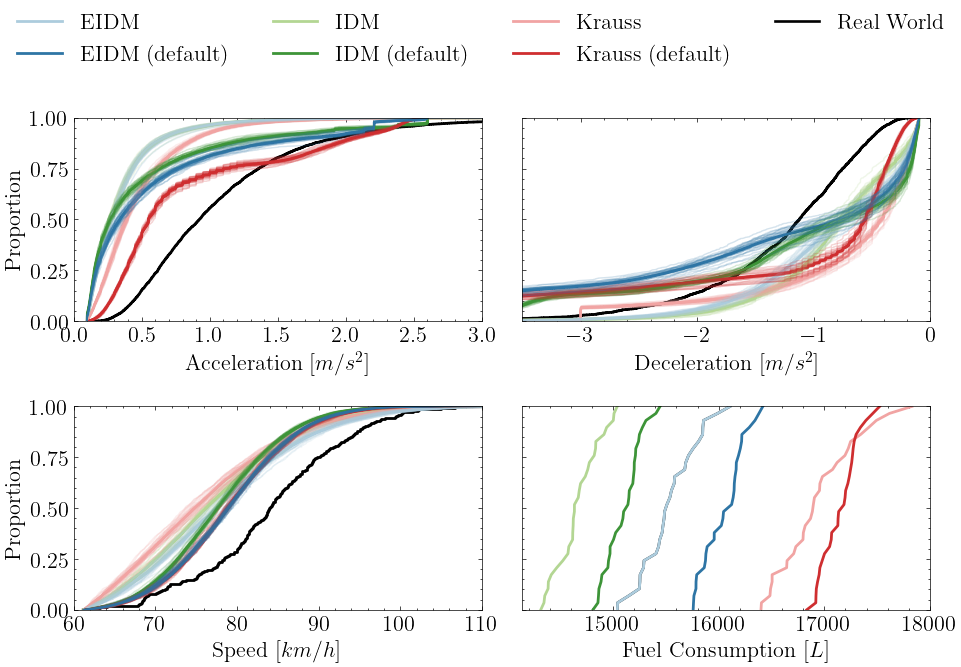

In [80]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend import _get_legend_handles_labels

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})


fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)
colors = sns.color_palette("Paired", 8, desat=0.8)

color_map = {}
models = list(east_thru_df["carFollowingModel"].unique()) + ["Real World"]
# sort the models alphabetically
models.sort()
for i, model in enumerate(models):
    color_map[model] = colors[i]
    if model == "Real World":
        color_map[model] = "black"


# plotting acceleration with r2 > 0.9
create_ecdf(
    ax[0, 0],
    color_map,
    "accel",
    0.9,
    (0, 3),
    "slope",
    "Acceleration [$m/s^2$]",
    show_legend=False,
)
# # plotting deceleration with r2 > 0.9
create_ecdf(
    ax[0, 1], color_map, "decel", 0.9, (-3.5, 0), "slope", "Deceleration [$m/s^2$]"
)
# plot the speed with r2 > 0.9
create_ecdf(ax[1, 0], color_map, "cruise", 0.9, (60, 110), "speed", "Speed [$km/h$]")

# add in the fuel consumption histogram
sns.lineplot(
    x=np.sort(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values),
    y=np.linspace(
        0, 1, len(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values)
    ),
    ax=ax[1, 1],
    color=color_map["Real World"],
    alpha=1,
    linewidth=1.9,
    label="Real World",
)

for model in models:
    if model == "Real World":
        continue

    data = fuel_df[fuel_df["carFollowModel"] == model]["fuel"].values
    sns.lineplot(
        x=np.sort(data),
        y=np.linspace(0, 1, len(data)),
        ax=ax[1, 1],
        color=color_map[model],
        alpha=1,
        linewidth=2,
        label=model,
    )

ax[1, 1].set_xlabel("Fuel Consumption [$L$]")
h, l = ax[1, 1].get_legend_handles_labels()
# switch the first and last legend
h = h[1:] + [h[0]]
l = l[1:] + [l[0]]
fig.legend(h, l, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1))
# remove the legend from 1,1
ax[1, 1].legend_.remove()


### Create a Latex table of the mean and median values for each model


In [ ]:
table = create_table(
    0.9,
)


(0.0, 3.5)

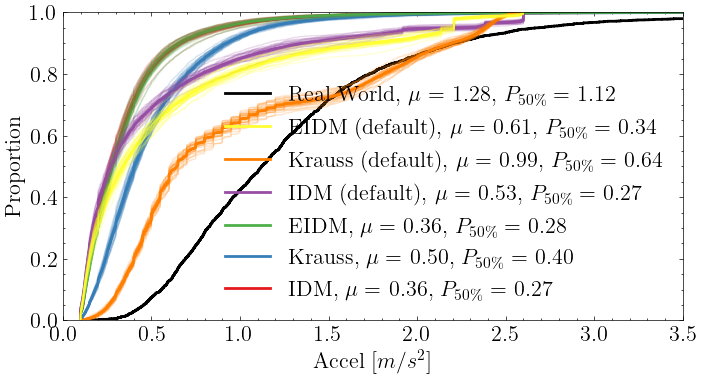

In [163]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["r2"] > 0.95)
    & (east_thru_df["type"] == "accel")
    & (east_thru_df["minimum_time"] > 0)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["r2"] > 0.95) & (rw_df["type"] == "accel") & (rw_df["minimum_time"] > 0)
].copy()
accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])

colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"


sns.ecdfplot(
    data=plot_df,
    x="slope",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "slope"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['slope'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['slope'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Accel [$m/s^2$]")

# set the x and y axis limits
ax.set_xlim(0, 3.5)


KeyboardInterrupt: 

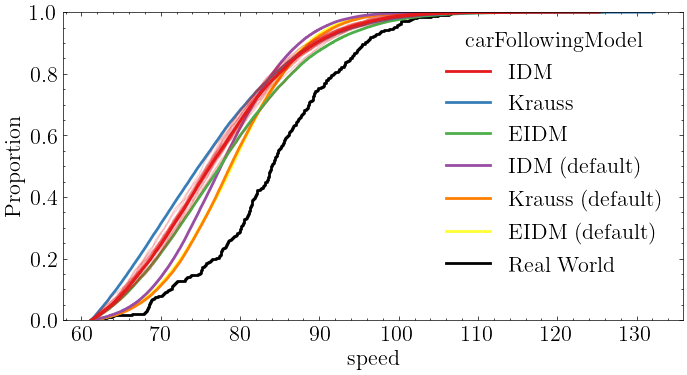

In [127]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["rmse"] < 0.05)
    & (east_thru_df["type"] == "cruise")
    & (east_thru_df["speed"] > 17)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["rmse"] < 0.05) & (rw_df["type"] == "cruise") & (rw_df["speed"] > 17)
].copy()

accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])
plot_df["speed"] = plot_df["speed"] * 3.6


colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"

sns.ecdfplot(
    data=plot_df,
    x="speed",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "speed"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# # sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# # remove the carFollowingModel title from the legend
# ax.legend_.set_title(None)

# # set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['speed'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['speed'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Speed [km/h]")


# set the x and y axis limits
ax.set_xlim(55, 120)


In [82]:
cruise_df["speed"].describe()


count    44.000000
mean     48.194663
std       7.517375
min      33.931664
25%      42.682669
50%      48.640121
75%      53.562594
max      62.983520
Name: speed, dtype: float64

In [68]:
slow_down_vehicles = rw_df.groupby("vehicle_id")["type"].apply(
    lambda x: any(x.str.contains("decel"))
)


In [69]:
slow_down_vehicles.sum() / slow_down_vehicles.shape[0]


0.8923151047940255

In [70]:
keep_vehicles = slow_down_vehicles[slow_down_vehicles == False].index


array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

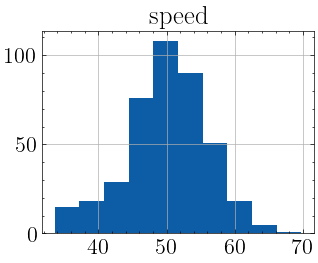

In [71]:
cruise_df.loc[cruise_df.vehicle_id.isin(keep_vehicles)].hist(
    column="speed",
)
